# Influence Over Inference

## Abstract

<img src="./images/torched-pie.jpeg" />
<figcaption style="text-align:center">A Torched Pie</figcaption>

The stock in trade of machine learning (ML) practitioners is the development and interpretation of ML models and what those models say about the data upon which they operate. Models can tell us the best place and time to plant a crop, whether or not a chest x - ray indicates the presence of disease, or the types of video entertainment most likely to sustain a new studio enterprise. Machine algorithms have become important factors in the decision - making process across numerous domains. Self - driving cars rely on them, for street sign recognition. Real estate developers use them to identify areas ripe for profitable development. Think tanks leverage them to predict and to recommend options for avoiding or mitigating widespread hunger.

In addition to analyzing what an ML model can tell us about our data, of increasing interest is identifying what training data can tell us about our model. It has been argued that bias - free ML models do not exist. This is a reasonable assumption, considering the fact that training data is finite and cannot possibly represent all possible outcomes. Data may also be vulnerable to basic error, such as incorrect labeling. So, it is a useful undertaking to consider what features of training data, when only slightly altered, can flip the outcome of a model prediction.

Toward such an endeavor, the Influence Function package for PyTorch, a deep learning library for Python, provides a method by which ML practitioners may gain insight into factors that effect outsized influence over data classification.

This project explores implementation of the PyTorch Influence Function package on a Neural Network model, for an image classification task. It is based on the (nimarb)[https://github.com/nimarb] reimplementation of Influence Functions from the ICML2017 best paper: (Understanding Black-box Predictions via Influence Functions)[https://arxiv.org/abs/1703.04730] by Pang Wei Koh and Percy Liang. The reference implementation can be found (here)[https://github.com/kohpangwei/influence-release].

We use the __CIFAR-10__ image dataset to train and test a model. We then apply influence function algorithms, to find out which images have the greatest positive and negative impact on the model's classification predictions.

## Notebook Preparation

### Import Torch.
We will begin by importing the PyTorch library

In [1]:
import torch
torch.__version__

'1.5.0'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Import and test for CUDA.
CUDA enables PyTorch to utilize a GPU for computation.

In [3]:
from torch import cuda # to access gpu

Verify the CUDA import and related configuration.

In [4]:
# verifying cuda
torch.cuda.is_available()

True

In [5]:
# checking cuda version
torch.version.cuda

'10.1'

In [6]:
# getting ID of gpu device
torch.cuda.current_device()

0

In [7]:
# checking that cuda is initialized
torch.cuda.is_initialized()

True

In [8]:
# printing gpu device name
torch.cuda.get_device_name(0)

'GeForce GTX 1660 Ti'

In [9]:
# listing in - memory torch packages
!conda list torch

# packages in environment at C:\Users\jamel\AppData\Local\Continuum\anaconda3\envs\pytorch-env:
#
# Name                    Version                   Build  Channel
_pytorch_select           1.1.0                       cpu  
pytorch                   1.5.0           py3.6_cuda101_cudnn7_0    pytorch
pytorch-influence-functions 0.1.1                    pypi_0    pypi
torchvision               0.6.0                py36_cu101    pytorch


In [10]:
# setting device to gpu if cuda is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# verifying that cuda is initialized
torch.cuda.is_initialized()

True

In [12]:
# viewing system information summary
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', )
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 14:00:49) [MSC v.1915 64 bit (AMD64)]
__pyTorch VERSION: 1.5.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:32:27_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.2, V10.2.89
__CUDNN VERSION: 7604
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


---
## TODO
* BUILD / LOCATE CONFIG FILE 
* BUILD TRAIN/TEST LOADERS
* BUILD MODEL

### Import and view path for influence functions package.

Most of our functions reside outside of the notebook, so we need to tell python where to find them.

In [13]:
# inmporting influence functions
import pytorch_influence_functions as ptif
import os

# viewing current directory
%pwd

'C:\\Users\\jamel\\flatiron\\Capstone\\pytorch_influence_functions\\examples-2'

In [14]:
# show ptif filepath 
ptif.__file__

'C:\\Users\\jamel\\AppData\\Local\\Continuum\\anaconda3\\envs\\pytorch-env\\lib\\site-packages\\pytorch_influence_functions\\__init__.py'

***

## Obtain and Scrub

The `torchvision` package allows us to import __CIFAR-10__ and other datasets natively linked to the `PyTorch` library. In this case, scrubbing or cleaning data comprises transforming the data to tensors, normalizing the data, and shuffling the training set to load it in randomized batches.

In [15]:
# importing torchvision package, for loading data, transforms and optimizers
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# def load_data():
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# return trainloader, testloader


Files already downloaded and verified
Files already downloaded and verified


In [16]:
# verifying CUDA availability, before training
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Explore

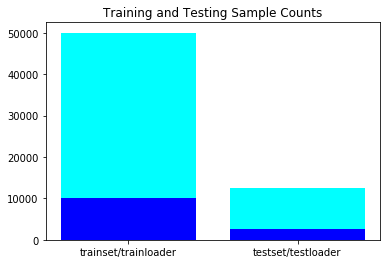

      number of samples in 'trainset':     50000
      number of samples in 'trainloader':  12500

      number of samples in 'testset':      10000
      number of samples in 'testloader':    2500


In [17]:
x1 = len(trainset)
x2 = len(trainloader)
x3 = len(testset)
x4 = len(testloader)

# Make a fake dataset:
height = [x1, x2]
bars = ('trainset', 'testset')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height, color=['aqua', 'aqua'])

# Make a fake dataset:
height = [x3, x4]
bars = ('trainset/trainloader', 'testset/testloader')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height, color=['blue', 'blue'])

  
# Create names on the x-axis
plt.xticks(y_pos, bars)

# creating title
plt.title('Training and Testing Sample Counts')

# Show graphic
plt.show()


print("      number of samples in 'trainset':    ", len(trainset))
print("      number of samples in 'trainloader': ", len(trainloader))
print("\n      number of samples in 'testset':     ", len(testset))
print("      number of samples in 'testloader':   ", len(testloader))

* Out of fifty-thousand samples in the __training__ dataset, we have loaded 25\% of them for training our model.
* Out of ten-thousand samples in the __test__ dataset, we have loaded 25\% of them for testing our model.

### Classes

In [18]:
# instantiate globally the 10 classes for the dataset
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Visualize Training Images

In [19]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

We can iterate through our trainloader and use torchvision to view a grid of images along with their labels.

      bird      truck        cat       bird


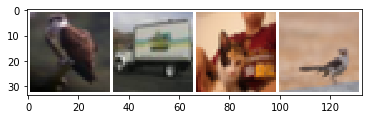

In [20]:
# visualizing a batch of training data
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images,
                                    nrow=4,
                                    padding=1,
                                    normalize=False,
                                    range=None,
                                    scale_each=True,
                                    pad_value=1))

# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

These are small images, so they appear a bit blurry to the human eye. Machine learning (ML) models 'see' them a bit differently, through the various filters of model algorithms, layers, and the feature maps they produce.

## Computer Vision

As an example of the ways that machines 'view' images, we can plot each rgb channel of an image in grayscale with annotations, to visualize the color value for each pixel in each of the 3 channels.

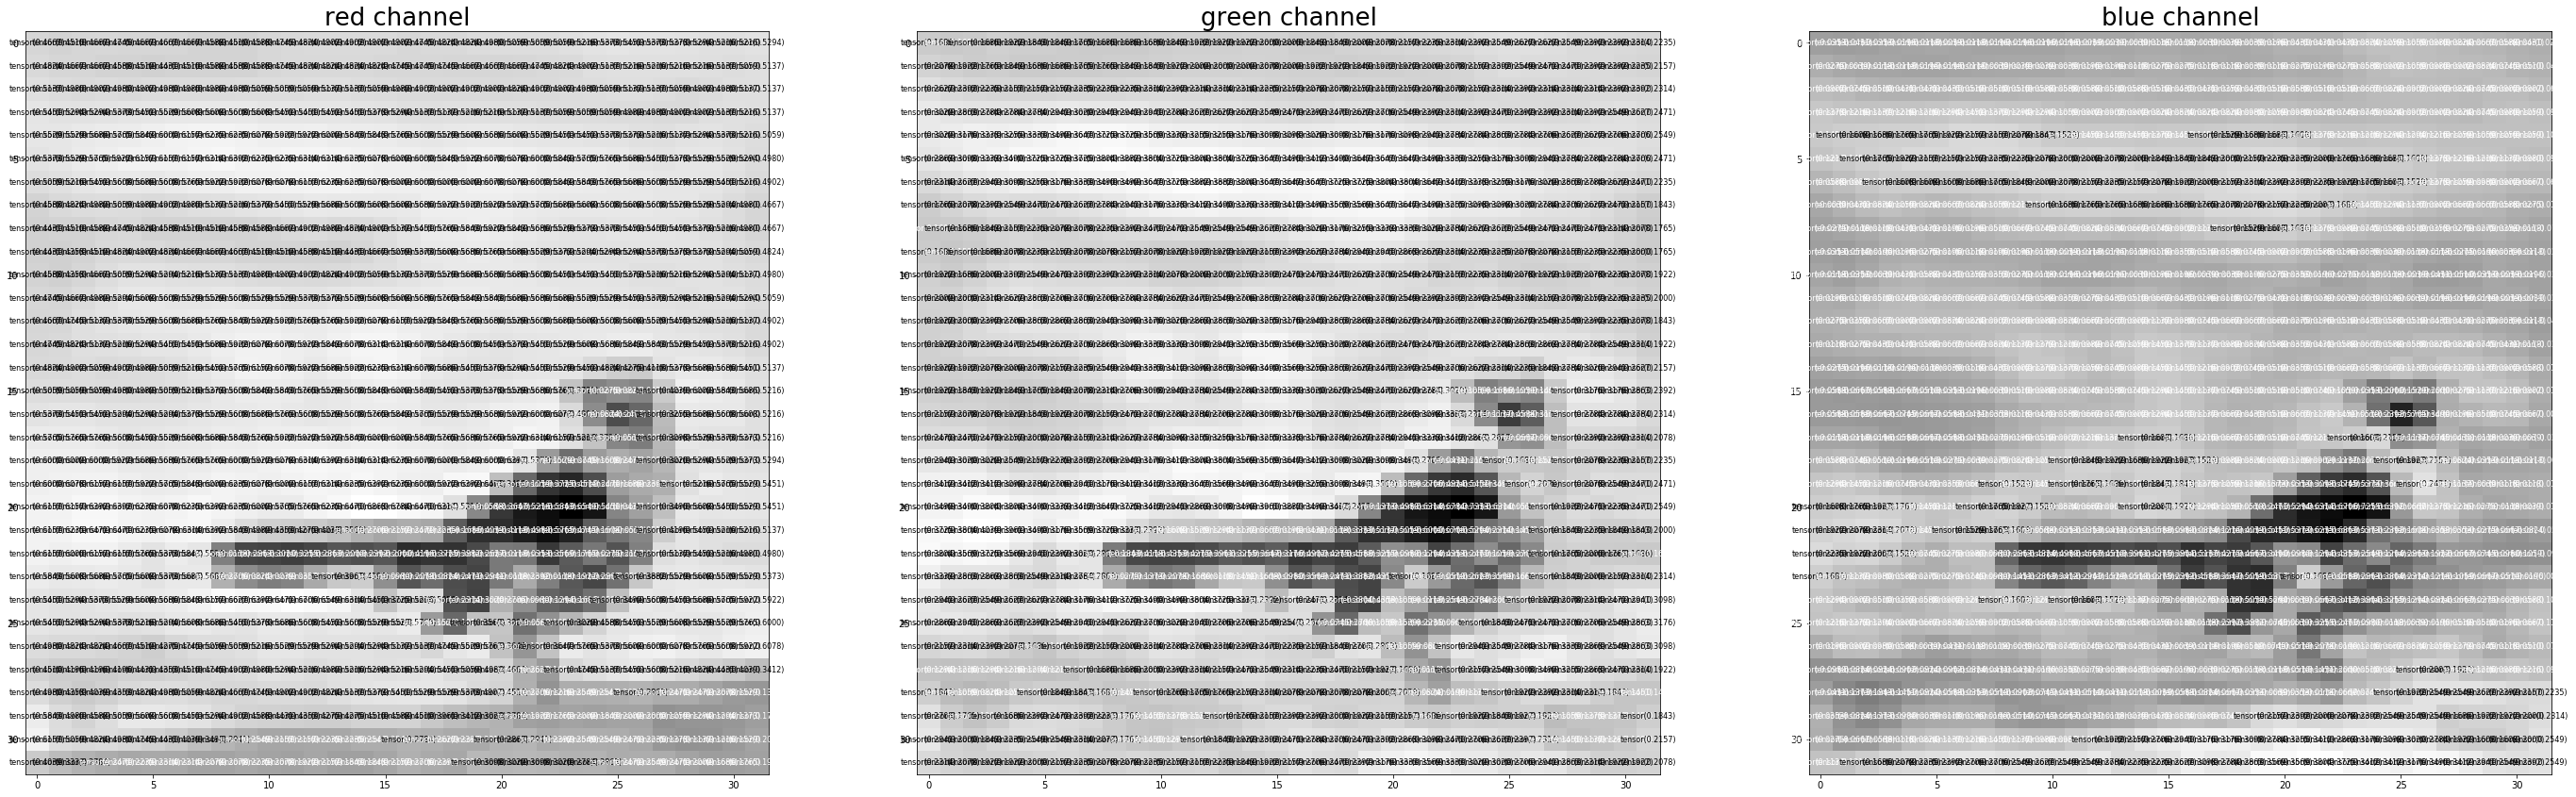

In [23]:
# viewing each color channel in grayscale
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (48, 48))
font = {'size': 26}
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(2, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx], fontdict=font)
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = img[x][y] if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

Each pixel in the triptych above represents only how much of a single color is reflected in that particular pixel, labeled with its tensor. We can make out how some features that are noticeable in one channel are less apparent in another. A dog's right eye might appear as a red and green mixture of brown in rgb color but be nearly invisible in the grayscaled blue channel alone.

## Model
PyTorch facilitates the creation of neural network models as class objects, with layers and propagation defined as python functions within the class.

Here, we will also define model training, along with functions to save, load, and test on the model.

In [21]:
# Build and train a model.


## = removed / relocated from external mode

# building the model as class objects
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# creating a function to train the model
def train(trainloader, testloader, net):
    # set criterion and optimizer parameters and hyperparameters
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    
    # print the loss at each epoch
    for epoch in range(10):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            #inputs, labels = data
            inputs, labels = data[0].cuda(), data[1].cuda()

            # zero the parameter gradients so that the gradients computed
            # previously do not interfere with the ones you are currently computing
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

## related functions for later use:

# saving the trained model
def save_model(net):
    PATH = './cifar_net2.pth'
    torch.save(net.state_dict(), PATH)

# (re)loading the trained model
def load_model():
    PATH = './cifar_net2.pth'
    net = Net()
    net.load_state_dict(torch.load(PATH))
    net.cuda()
    return net


# creating a function to test the model
def test(testloader, net):
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            #images, labels = data
            images, labels = data[0].cuda(), data[1].cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            _, pred = torch.max(outputs, 1)
            c = (pred == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))


# training the model on the GPU
# if __name__ == "__main__":
#     trainloader, testloader = load_data()
model = Net()
model.cuda()
train(trainloader, testloader, model)



[1,  2000] loss: 2.183
[1,  4000] loss: 1.868
[1,  6000] loss: 1.665
[1,  8000] loss: 1.556
[1, 10000] loss: 1.524
[1, 12000] loss: 1.458
[2,  2000] loss: 1.404
[2,  4000] loss: 1.400
[2,  6000] loss: 1.324
[2,  8000] loss: 1.332
[2, 10000] loss: 1.322
[2, 12000] loss: 1.283
[3,  2000] loss: 1.230
[3,  4000] loss: 1.216
[3,  6000] loss: 1.216
[3,  8000] loss: 1.193
[3, 10000] loss: 1.200
[3, 12000] loss: 1.182
[4,  2000] loss: 1.113
[4,  4000] loss: 1.117
[4,  6000] loss: 1.129
[4,  8000] loss: 1.144
[4, 10000] loss: 1.119
[4, 12000] loss: 1.100
[5,  2000] loss: 1.021
[5,  4000] loss: 1.044
[5,  6000] loss: 1.050
[5,  8000] loss: 1.059
[5, 10000] loss: 1.046
[5, 12000] loss: 1.082
[6,  2000] loss: 0.968
[6,  4000] loss: 0.986
[6,  6000] loss: 1.009
[6,  8000] loss: 0.993
[6, 10000] loss: 1.018
[6, 12000] loss: 0.998
[7,  2000] loss: 0.900
[7,  4000] loss: 0.964
[7,  6000] loss: 0.961
[7,  8000] loss: 0.967
[7, 10000] loss: 0.946
[7, 12000] loss: 0.968
[8,  2000] loss: 0.881
[8,  4000] 

> Keep in mind that our goal is not to design a perfect model; practically any model will do. We are interested in the capability for PyTorch's `influence function` package to identify inputs that have outsized influence over the model's overall accuracy, for better or for worse.

### Save the trained model.

In [22]:
# saving the model
save_model(model)

---

## Visualize Test Results

In [1]:
# plotting the matrix
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)

# perform inference on the test set and plot the model's accuracy
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('\nModel accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

NameError: name 'np' is not defined

We get a sense of the rate at which the model successfully predicted samples from each class.

In [32]:
# viewing a confusion matrix for model predictions and actual classes

# print column labels
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()

# print prediction counts
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

    # print prediction ratios
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print("\n", "-"*85)

actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           620       57        41        24        45        5         13        31        125       39        
                0.62      0.057     0.041     0.024     0.045     0.005     0.013     0.031     0.125     0.039     
 -------------------------------------------------------------------------------------
car             16        837       3         15        5         5         11        9         35        64        
                0.016     0.837     0.003     0.015     0.005     0.005     0.011     0.009     0.035     0.064     
 -------------------------------------------------------------------------------------
bird            88        15        418       75        183       40        52        78        32        19        
                0.088     0.015     0.418     0.075     0.183     0.04      0.052     0.078     0.032     0.019     
 ------

## Calculate influence for the trained model.

At the heart of our project is less the accuracy of the model and more the search to determine which training images have the most influence over our model accuracy.

PyTorch's influence function package makes this possible, calculating which images were most harful and which were most helpful.

In [24]:
# using default influence function configuration
config = ptif.get_default_config()

# reloading the model and re - instantiating dataloaders
model = load_model()
net = model            # add for line 27
# trainloader, testloader = load_data()

# creating/define logfile
ptif.init_logging('logfile.log')

# calculating influence
ptif.calc_img_wise(config, model, trainloader, testloader)

#####################
# running a test
# test(testloader, model)
# deconstructing the test function to make variables global
#####################
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        #images, labels = data
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        _, pred = torch.max(outputs, 1)
        c = (pred == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

2020-05-14 18:19:51,992: Running on: 1 images per class.
2020-05-14 18:19:51,994: Starting at img number: 0 per class.


C:\Users\jamel\AppData\Local\Continuum\anaconda3\envs\pytorch-env\lib\site-packages\pytorch_influence_functions\influence_function.py:69: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y = torch.nn.functional.log_softmax(y)


Calc. s_test recursions: [=================================================] 1 / 1
Averaging r-times: [=======================================================] 1 / 1
Calc. influence function: [========================================] 49999 / 50000
Calc. influence function: [========================================] 50000 / 50000
Calc. s_test recursions: [=================================================] 1 / 1
Averaging r-times: [=======================================================] 1 / 1
Calc. influence function: [========================================] 49999 / 50000
Calc. influence function: [========================================] 50000 / 50000
Calc. s_test recursions: [=================================================] 1 / 1
Averaging r-times: [=======================================================] 1 / 1
Calc. influence function: [========================================] 49999 / 50000
Calc. influence function: [========================================] 50000 / 50000
Calc

Running `Influence Functions` over our model, with the current dataset, took about 90 minutes. This may seem like a relatively expensive, in this application. However, one can perceive its value for non - trivial applications (e.g., improving object segmentation modeling from aerial imagery for use in humanitarian response, damage assessment, or disaster recovery efforts).

Above, we can see "most harmful' and "most helpful" IDs, which we will instantiate in two lists, below. Note: _Since data is drawn from the full dataset in random batches, re - runs of our notebook and tests may result in the IDs below differing from those above._

In [25]:
# list the most harmful and helpful images
most_harmful = [874, 11580, 7083]
most_helpful = [1697, 2251, 48934]

## -- first run results
## most_harmful = [48263, 27228, 20391]
## most_helpful = [24987, 33778, 33028]


__View the 3 most harmful images__

In [26]:
# def image_by_index(h, figsize=(13.4)):
#     """
#     Takes a list of 3 image IDs (h), 
#     returns plots of related image data
#     """
#     fig = plt.figure(figsize=figsize)
#     for ind in np.arange(3):
#         ax = fig.add_subplot(1, 3, ind+1, xticks=[], yticks=[])
#         for idx, image in enumerate(trainloader.dataset):
#             if idx == h[ind]:
#                 imshow(image[0])

In [27]:
# image_by_index(most_harmful)

In [28]:
# image_by_index(most_helpful)

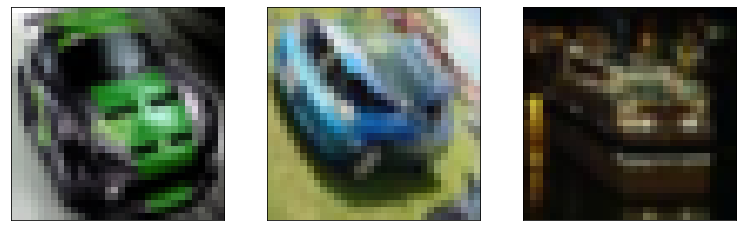

In [29]:
# creating a figure for the 3 images
# by matching trainloader indexes to those in our lists
fig = plt.figure(figsize=(13, 4))
for ind in np.arange(3):
    ax = fig.add_subplot(1, 3, ind+1, xticks=[], yticks=[])
    for idx, image in enumerate(trainloader.dataset):
        if idx == most_harmful[ind]:
            imshow(image[0])
#             ax.set_title("{}({})".format(str(preds[idx].item()),str(labels[idx].item()))
#              ,color=("green" if preds[idx]==labels[idx] else "red"))  

>* The model was most accurate (79\%) in its predictions for the `car` class.
* The influence function suggests that model accuracy may be further (and most) harmed by upweighting features related to these three images.

__View the 3 most helpful images__

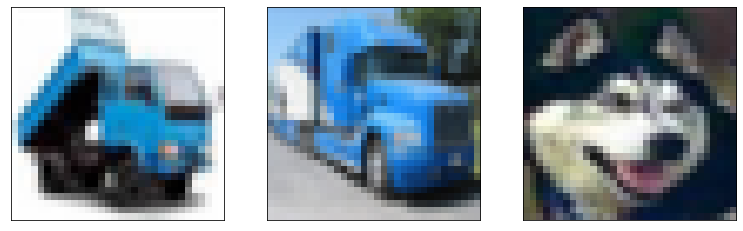

In [30]:
fig = plt.figure(figsize=(13, 4))

for ind in np.arange(3):
    ax = fig.add_subplot(1, 3, ind+1, xticks=[], yticks=[])
    for idx, image in enumerate(trainloader.dataset):
        if idx == most_helpful[ind]:
            imshow(image[0])

plt.show()

> * The model was 69\% accurate in its predictions for the `truck` class.
* The influence function identifies features related to the three images above as most helpful to the model, overall.
* It is, perhaps, also worth noting that __pickup trucks__ are included in CIFAR-10's `car` class, not in the `truck` class.

# Conclusion

The influence function identifies specific samples within classes that have a significant effect, for better or for worse, on model performance. The correlation matrix of our results reveals weak accuracy (indicated by relatively light coloration on the top - left - to - bottom - right diagonal) where the `predicted` column intersects with `actual` row for the same class. 

Next steps may include:

    * Testing data from a single class, with and without the images found most hepful and most harmful.
    * Validating correct labeling in the training set, as mislabeled data can throw - off both our model and our analysis of its influences. __FULL DISCLOSURE__: This project marks my first time using PyTorch and Influence Functions, so I am still working out where predicted labels are locally stored.
    * Altering the weights within the model for these influential image features, to see how we can improve accuracy for the related classes. Alternately, we could 'stress - test' our model, to identify how it might be undermined via minor changes (perturbations) to image data.
    * In addition--while the notebook is useful for exploration, analysis, and interpretation--we would want to restore the classes and functions for this process to a productionized environment. Classes and modules would be maintained in separate python files. The files could then be packaged such that new models can be passed - in for influence function analysis.

Applications for influence functions may include (in addition to non - trivial applications noted above) the following:
    * Verify data labels, to prevent mis - labeled data from compromising the integrity of models.
    * Robust authentication of valuables or even identity that is not overly - reliant on influential features
    * De - bugging in practically any domain that uses ML models

---

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@